# Predicting the rank of Starcraft II players

**Ethan Shapiro**

## Summary of Findings


### Introduction
**My Questions:** Can we predict a Starcraft player's rank based on their past ranked performance? If so, what information is useful and or will be useful to collect for future prediction?

**Type of Prediction Problem:** We're doing a multiclass classification on the player's rank.

**Response Variable:** League Index (Ranks 1-8)

Finding a solution to these problems I see could help us a few ways:

*From a gamer maker perspective*
1. Placing veteran players in the new ranked season
2. Placing new players into their first ranked league
3. Working in conjunction with another model to adjust ranks (ranked reset, rank inflation adjustments, etc.)

*From an esports organization perspective*
1. Evaluating if the player is "meant" to be in the rank they are at
2. Understanding what is important to be a higher tier player to help our player's improve 

**Metric:** I chose accuracy for evaluating the model because we want to weigh false positives and false negatives equally in our outcomes.

---
### Cleaning and Feature Selection
---



We performed cleaning on 3 different complainant columns:
 - ethnicity
    - There were missing ethnicities labeled as "Unknown", so we changed those to NaN
    - We were not working with ethnicities, so there was no reason to impute these values
 - gender
    - There were missing genders labeled as "Unknown", so we changed those to be NaN
    - We were not working with genders, so there was no reason to impute these values
 - age
    - There were negative or 0 ages which aren't possible, so we changed those to NaN
    - We did not impute these values because we did not use them to answer our question in the beginning
    - There were also ages which were 5 or less, but we can't say for certain someone that age didn't make a complaint, so we didn't change those values.
 
 Since ethnicity, gender, and age are all reported by the complainant, they can choose not to give this information, which is why certain
 complaints do not include these attributes.

Next, we engineered two different features:
   - Duration the complaint was open
      - We used the complaint received date and the complaint closed date to get the number of days the complaint was open
   - Complaint Outcome
      - We used the original complaint outcome which contained a lot of sub-categories. We removed those categories and simplified it to either an action taken or not.

### Baseline Model
For our baseline model, we chose to use a **Decision Tree Classifier**.

We included these features:
 - **Officer Age at the incident (mos_age_incident)**
    - Type: Quantitative
    - Encoding: None
 - **Officer Ethnicity (mos_ethnicity)**
    - Type: Categorical
    - Encoding: One Hot Encoding
 - **Officer Gender (mos_gender)**
    - Type: Categorical
    - Encoding: One Hot Encoding
 - **Complainant Ethnicity (complainant_ethnicity)**
    - Type: Categorical
    - Encoding: One Hot Encoding
 - **Complainant Gender (complainant_gender)**
    - Type: Categorical
    - Encoding: One Hot Encoding
 - **Complainant Age (complainant_age_incident)**
    - Type: Quantitative
    - Encoding: None
 - **Type of Complaint (fado_type)**
    - Type: Categorical
    - Encoding: One Hot Encoding
    
We were trying to predict: **Outcome of Complaint (complaint_outcome)**

Our Basic Model's performance was:
 - Test accuracy: ~0.4944
 - Test precision: ~0.4628
 
We don't believe our model is good because it doesn't do significantly better than simply randomly guessing an outcome (which would be ~33%).<br>
There is no point to telling a complainant a possible outcome if we are not even 50% sure of our prediction.

### Final Model
For our final model, we stuck with a **Decision Tree Classifier**.

We feature engineered the following:
 - **Officer is a Minority**
    - *Type:* Categorical/Binary
    - *Encoding:* Returning any ethnicity non-white as a 1 and white as a 0.
    - *Why it's a good fit:* We believe there could be bias in the CCRB decision process based on ethnicity. Therefore, knowing if an officer is a minority might give information about the outcome of the complaint.
 - **Complainant is a Minority**
    - *Type:* Categorical/Binary
    - *Encoding:* Returning any ethnicity non-white as a 1 and white as a 0.
    - *Why it's a good fit:* We believe there could be bias in the CCRB decision process based on ethnicity. Therefore, knowing if a complainant is a minority might give information about the outcome of the complaint.
 - **Officer is a High Rank**
    - *Type:* Categorical/Binary
    - *Encoding:* Returning 1 for Deputy Inspector, Inspector, and Chief/other high ranks. Returning 0 otherwise.
    - *Why it's a good fit:* Higher ranking officers might have more favorable outcomes than lower ranking officers. Therefore, knowing if the rank is a high rank can help us predict the outcome.
 - **General Allegation Type**
    - *Type:* Categorical
    - *Encoding:* We take the original 76 unique allegation types and categorize them into 11 general groups. Then, we were able to One Hot Encode them.
    - *Why it's a good fit:* We believe the severity of the complaint will give information about the outcome of the complaint. I.E. More severe complaint allegations might be more likely to be Substantiated and vice-versa.
 - **General Outcome Type**
    - *Type:* Categorical/Ordinal
    - *Encoding:* We generalized the original outcome types into three major types: Arrest, Summons, or No Arrest. Then, we ordinally encoded it, making Arrest the most severe outcome, followed by Summons, and then No Arrest.
    - *Why it's a good fit:* We believe the outcome of the Officer and Complainant interaction can influence the decision of the CCRB. I.E. If someone is arrested during the interaction, their complaint might be out of spite and not necessarily true.

After creating these features, we ran a **GridSearchCV** with a **Decision Tree**, **5 folds**, and fitted on **75%** of the original data. We ended up with the following best hyperparameters:
 - criterion: entropy
 - max_depth: 12
 - min_samples_split: 15

Our Final Model's performance was:
 - Test accuracy: ~0.5349
 - Test precision: ~0.5408

This means our model improved its accuracy by ~4.05% and its precision by ~7.80%.

### Fairness Analysis

We ran a permutation Tests to test our model's **precision** of Minority vs. Non-Minority Complainants with the following hypotheses:

<b>Null Hypothesis:</b> Our model is fair. Its precision for minorities and non-minorities are roughly the same, and differences are due to random chance.

<b>Alternative Hypothesis:</b> Our model is unfair. Its precision for minorities is better than for minorities than non-minorities.

<b>Evaluation Metric:</b> Precision

<b>Our signifcance value:</b> 0.05

With a p-value = 0.013 < 0.05, we reject the null hypothesis and say that our model is unfair.
Our model has worse precision for complainants that are non-minorities than it does for minorities.

---
## Imports

In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings('ignore')

----
## Feature Cleaning and Missigness
----
Here, I'll explain why I removed particular features and how I dealt with missingness in the data.

We were trying to predict: **LeagueIndex**

With that multi-class classification objective in mind, I **removed** these features:
 - **GameID**
   - Knowing a GameID is great than 10,000 leaks information into the model to identify Professional Players (League Index 8).
   - We want to identify a player's rank based off of their skills, not a unique ID.
 - **Age**
   - The age of the player didn't give any information on the player's rank, so we can simply remove it.
   - This also solves a problem with having missing values for only rank 8, which makes it hard to impute good values.
 - **TotalHours**
   - Knowing the total hours a player has didn't give us good insight into their rank.
   - All of rank 8 players are missing this entry which would make it hard to impute good values.
   - The 'HoursPerWeek' feature did a better job of capturing the amount of hours played with regards to player rank.
  - **HoursPerWeek**
   - Although this metric did show some correlation to our target, I removed it because of a two reasons:
      1. All of the values for League Index 8 are missing, so it would be hard to impute unbiased values and also impossible to use basic metrics (mean, etc.)
      2. Imputing a filler value will introduce bias
   - **How I could attempt to impute them with more time**
      - League Index 8 missingness:
        - Attempting to build a model between HoursPerWeek and other features to impute the values
      - League Index 5 missingness:
        - Within the League Index 5 entries, I would use the Age of the player to impute the mean
----

An initial observation is that all of the columns are numeric and at vastly different scales. When using different models or techniques to explore the data I'll think about standardizing the data.

In [30]:
# Read in the data
df = pd.read_csv('starcraft_player_data.csv')
df.head(1)

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.718,0.003515,0.00022,7,0.00011,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.0


It appears that no NaN values are present in the data, but we'll take a closer look to see if missingness presents itself in other ways>

In [31]:
# See if we have any missing values
df.isna().sum()

GameID                  0
LeagueIndex             0
Age                     0
HoursPerWeek            0
TotalHours              0
APM                     0
SelectByHotkeys         0
AssignToHotkeys         0
UniqueHotkeys           0
MinimapAttacks          0
MinimapRightClicks      0
NumberOfPACs            0
GapBetweenPACs          0
ActionLatency           0
ActionsInPAC            0
TotalMapExplored        0
WorkersMade             0
UniqueUnitsMade         0
ComplexUnitsMade        0
ComplexAbilitiesUsed    0
dtype: int64

In [32]:
# Seems to be no missing values, but let's take a look at our column types to find any "hidden" missingness
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3395 entries, 0 to 3394
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   GameID                3395 non-null   int64  
 1   LeagueIndex           3395 non-null   int64  
 2   Age                   3395 non-null   object 
 3   HoursPerWeek          3395 non-null   object 
 4   TotalHours            3395 non-null   object 
 5   APM                   3395 non-null   float64
 6   SelectByHotkeys       3395 non-null   float64
 7   AssignToHotkeys       3395 non-null   float64
 8   UniqueHotkeys         3395 non-null   int64  
 9   MinimapAttacks        3395 non-null   float64
 10  MinimapRightClicks    3395 non-null   float64
 11  NumberOfPACs          3395 non-null   float64
 12  GapBetweenPACs        3395 non-null   float64
 13  ActionLatency         3395 non-null   float64
 14  ActionsInPAC          3395 non-null   float64
 15  TotalMapExplored     

We expect the Age, Hours per week, and Total Hours to be numeric types, so let's check those columns to see if anything is out of place

In [33]:
# Age, HoursPerWeek, and TotalHours have ?'s in place for missing values
unique_ages = df['Age'].unique()
non_numeric_ages = [not x.isnumeric() for x in unique_ages]
print(f"Non-numeric entries in 'Age': {unique_ages[non_numeric_ages]}")
num_non_numeric_entries = df[df['Age'].isin(unique_ages[non_numeric_ages])].shape[0]
print(f"Number of Ages with '?': {num_non_numeric_entries}")
print()

unique_hrsperweek = df['HoursPerWeek'].unique()
non_numeric_hrsperweek = [not x.isnumeric() for x in unique_hrsperweek]
print(f"Non-numeric entries in 'HoursPerWeek': {unique_hrsperweek[non_numeric_hrsperweek]}")
num_non_numeric_entries = df[df['HoursPerWeek'].isin(unique_hrsperweek[non_numeric_hrsperweek])].shape[0]
print(f"Number of HoursPerWeek with '?': {num_non_numeric_entries}")
print()

unique_totalhrs = df['TotalHours'].unique()
non_numeric_totalhrs = [not x.isnumeric() for x in unique_totalhrs]
num_non_numeric_entries = df[df['TotalHours'].isin(unique_totalhrs[non_numeric_totalhrs])].shape[0]
print(f"Non-numeric entries in 'TotalHours': {unique_totalhrs[non_numeric_totalhrs]}")
print(f"Number of TotalHours with '?': {num_non_numeric_entries}")
print()


Non-numeric entries in 'Age': ['?']
Number of Ages with '?': 55

Non-numeric entries in 'HoursPerWeek': ['?']
Number of HoursPerWeek with '?': 56

Non-numeric entries in 'TotalHours': ['?']
Number of TotalHours with '?': 57



Replace '?' with NaN

In [34]:
df.loc[:, ['Age', 'HoursPerWeek', 'TotalHours']] = df[['Age', 'HoursPerWeek', 'TotalHours']].apply(lambda x: x.replace('?', np.NaN).astype(np.float64))

# we can verify we replaced the '?'s correctly
df[['Age', 'HoursPerWeek', 'TotalHours']].isna().sum()

Age             55
HoursPerWeek    56
TotalHours      57
dtype: int64

I'll convert the LeagueIndex column to a categorical type

In [35]:
df['LeagueIndex'] = df['LeagueIndex'].astype('category')

Before we consider removing these rows/columns, let's explore each of them to determine whether they explain anything about our target.

First, we we'll take a look at the distribution of missingness among our target variable, League Index.

In [36]:
df[df['Age'].isna()]['LeagueIndex'].value_counts()

LeagueIndex
8    55
1     0
2     0
3     0
4     0
5     0
6     0
7     0
Name: count, dtype: int64

The missing ages are all from the League 8, which means that the missingness is likely Not Missing At Random (NMAR). It was likely left out by choice during the data collection process and therefore will probably be absent from future data collection processes.

Before I completely remove Age column, I'll take a look at the distribution of Age in terms of the player's rank. If there isn't any significant trend, it's safe to say removing the Age column won't affect the model. 

Below, we can clearly see that there is no distinct trend for Age in regards to LeagueIndex, so we'll go ahead and remove the age column.

<Axes: xlabel='LeagueIndex', ylabel='Age'>

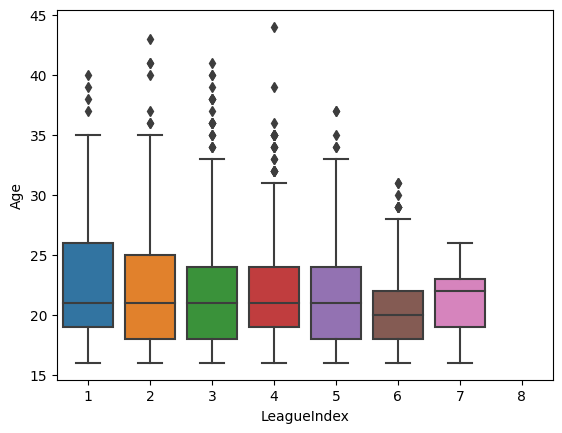

In [37]:
sns.boxplot(df, x='LeagueIndex', y='Age')

In [38]:
df = df.drop(['Age'], axis=1)

Next, we'll take a look at the 'HoursPerWeek' column and how that relates to our player's rank.

Below, we can see that the mean 'HoursPerWeek' spent on the game steadily increases as the player's rank increases.

In [39]:
df.groupby(['LeagueIndex'])[['HoursPerWeek']].agg(['min', 'max', 'mean'])

HoursPerWeek                  
                     min    max       mean
LeagueIndex                               
1                    2.0   70.0  13.125749
2                    2.0   72.0   13.29683
3                    2.0   80.0  13.949367
4                    2.0   96.0  14.022195
5                    2.0   96.0  16.183851
6                    0.0  168.0  21.088567
7                    6.0   98.0  31.714286
8                    NaN    NaN        NaN

Let's look at how each of our features is linearly correlated with our player's ranks below.

In terms of our columns with missing data, we can see that 'TotalHours' doesn't seem to have a strong linear correlation with LeagueIndex. We'll drop this column because it probably won't give us good insight into the player's ranks that we couldn't get from other columns.

On the other hand, 'HoursPerWeek' has a somewhat strong correlation with 'LeagueIndex', so we'll see if there is a way to impute the data later.

In [40]:
correlation_vals = df.corr().loc[:, ['LeagueIndex']].apply(lambda x: np.round(x, 2)).reset_index()

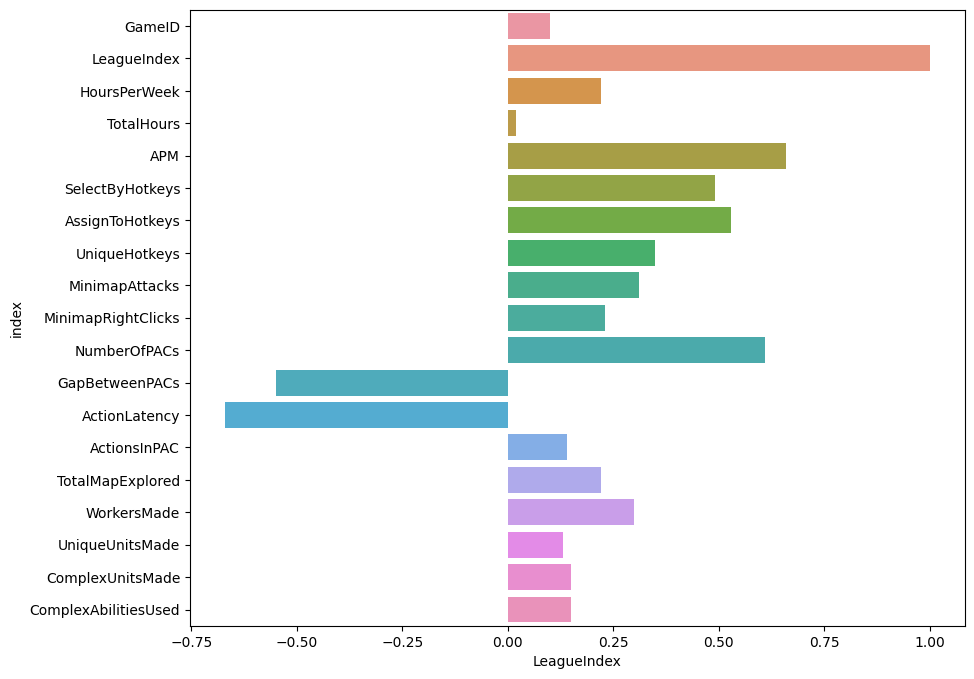

In [41]:
plt.figure(figsize=(10, 8))
sns.barplot(correlation_vals, x='LeagueIndex', y='index')
plt.show()

In [42]:
plt.figure(figsize=(1, 10))
px.bar(correlation_vals, x='index', y='LeagueIndex', color='LeagueIndex', text='LeagueIndex')

<Figure size 100x1000 with 0 Axes>

In [43]:
df = df.drop(['TotalHours'], axis=1)

The 'HoursPerWeek' is missing for every entry of League Index 8 and one for League Index 5. We'll remove this feature as well because I would need more time to impute good values.

In [44]:
df[df['HoursPerWeek'].isna()]['LeagueIndex'].value_counts()

LeagueIndex
8    55
5     1
1     0
2     0
3     0
4     0
6     0
7     0
Name: count, dtype: int64

In [45]:
df = df.drop(['HoursPerWeek', 'GameID'], axis=1)

----

## Models

----

I chose various models and tuned them using Grid Search Cross Validation. The best model turned out to be a Random Forests Classifier.

**Best Model**
- **Random Forest**
    - Train Accuracy: 100%
    - Test Accuracy: ~41.53%

**Other Models**
- **Logistic Regression Classification**
    - Train Accuracy: ~42.75%
    - Test Accuracy: ~38.88%
- **Gradient Boosted Regression**
    - Train Accuracy: 100.0%
    - Test Accuracy: ~39.47%
- **K Nearest Neighbors Classifier**
    - Train Accuracy: 100.0%
    - Test Accuracy: ~30.49%
- **Decisicon Tree Classifier**
    - Train Accuracy: 100.0%
    - Test Accuracy: ~30.49%
- **Support Vector Classifier**
    - Train Accuracy: 30.04
    - Test Accuracy: 28.87

In [46]:
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Param Tuning & Data Prep
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

# metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score

In [66]:
# Define the classifiers and their corresponding parameter grids for grid search
classifiers_params = [
    {
        'classifier': LogisticRegression(max_iter=50_000), # max_iter suppresses convergence warning
        'params': {
            'C': [0.1, 1, 10],
            'penalty': ['l1', 'l2'],
            'multi_class': ['ovr', 'multinomial']
        }
    },
    {
        'classifier': RandomForestClassifier(),
        'params': {
            'n_estimators': [100, 200, 500],
            'max_depth': [None, 5, 10, 15, 20]
        }
    },
    {
        'classifier': GradientBoostingClassifier(),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5, 10]
        }
    },
    {
        'classifier': SVC(),
        'params': {
            'C': [0.01, 1, 10],
            'kernel': ['rbf'],
            'decision_function_shape': ['ovr', 'ovo']
        }
    },
    {
        'classifier': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 11, 13, 15],
            'weights': ['uniform', 'distance']
        }
    },
    {
        'classifier': DecisionTreeClassifier(),
        'params': {
            'max_depth': [None, 5, 10]
        }
    },
    {'classifier': GaussianNB(),
     'params': {
     }}
]

For the baseline models, I'm going to dorp all of the columns containing missing values. In the final model, I'll impute values into the 'HoursPerWeek'.

In [67]:
# Define your dataset (X) and target variable (y)
X = df.drop(['LeagueIndex'], axis=1) 
y = df['LeagueIndex']

In [68]:
X = df.drop(['LeagueIndex'], axis=1)
y = df['LeagueIndex']

In [69]:
@ignore_warnings(category=ConvergenceWarning)
def perform_experiments(X_train, X_test, y_train, y_test) -> list:
    """
    Performs various classification models on the given test and train datasets.
    Prints each model's train and test accuracies.
    
    Returns a list of the best models.

    Args:
        X_train (_type_): _description_
        X_test (_type_): _description_
        y_train (_type_): _description_
        y_test (_type_): _description_

    Returns:
        list: _description_
    """
    best_models = []
    for classifier in classifiers_params:
        # perform gridsearch for the best params
        grid_search = GridSearchCV(classifier['classifier'], classifier['params'], cv=5, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        
        # save the best model
        best_model = grid_search.best_estimator_
        best_models.append(best_model)

        # Evaluate the best model on train and test sets
        train_accuracy = accuracy_score(y_train, best_model.predict(X_train))
        test_accuracy = accuracy_score(y_test, best_model.predict(X_test))

        # Print accuracy scores
        print("Classifier:", best_model.__class__.__name__)
        print("Train Accuracy:", 100 * np.round(train_accuracy, 4))
        print("Test Accuracy:", 100 * np.round(test_accuracy, 4))
        print()
    return best_models


In [70]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

# Perform grid search for each classifier
best_models_main = perform_experiments(X_train, X_test, y_train, y_test)

Classifier: LogisticRegression
Train Accuracy: 39.36
Test Accuracy: 39.76

Classifier: RandomForestClassifier
Train Accuracy: 100.0
Test Accuracy: 41.24

Classifier: GradientBoostingClassifier
Train Accuracy: 100.0
Test Accuracy: 40.94

Classifier: SVC
Train Accuracy: 38.769999999999996
Test Accuracy: 38.73

Classifier: KNeighborsClassifier
Train Accuracy: 100.0
Test Accuracy: 34.02

Classifier: DecisionTreeClassifier
Train Accuracy: 43.96
Test Accuracy: 38.440000000000005

Classifier: GaussianNB
Train Accuracy: 38.07
Test Accuracy: 38.59



In [71]:
random_forest_mdl = best_models_main[1]
confusion_matrix(random_forest_mdl.predict(X_test), y_test)

array([[10,  8,  4,  4,  0,  0,  0,  0],
       [ 7, 19, 12,  8,  3,  0,  0,  0],
       [ 8, 21, 36, 33,  5,  1,  0,  0],
       [ 7, 15, 49, 65, 49, 14,  0,  0],
       [ 0,  3, 15, 54, 77, 40,  0,  0],
       [ 0,  1,  0,  4, 22, 67,  6,  6],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  6]])

----

## Top Rank Focused Models

----

Taking the lense of an Esports organization, I would adjust the model to focus on the higher tier players (League Index 6 to 8 or Master to Professional). Knowing how to differentiate between lower tier players doesn't seem to be helpful to a professional team, but knowing who could potentially be a professional player would be. This could be made into a tool to help with obtaining and training EG's next Starcraft II players.

I chose various models and tuned them using Grid Search Cross Validation. The best model turned out to be a Random Forests Classifier.

**Best Model**
- **Random Forest**
    - Train Accuracy: 100%
    - Test Accuracy: ~41.53%

**Other Models**
- **Logistic Regression Classification**
    - Train Accuracy: ~42.75%
    - Test Accuracy: ~38.88%
- **Gradient Boosted Regression**
    - Train Accuracy: 100.0%
    - Test Accuracy: ~39.47%
- **K Nearest Neighbors Classifier**
    - Train Accuracy: 100.0%
    - Test Accuracy: ~30.49%
- **Decisicon Tree Classifier**
    - Train Accuracy: 100.0%
    - Test Accuracy: ~30.49%
- **Support Vector Classifier**
    - Train Accuracy: 30.04
    - Test Accuracy: 28.87

Below, we can see that there are two features with importances ~0.03. <br> Usually, I would remove them and rerun the models to see if our less complex model performs similarly to our first, but since our model is only 15 features it isn't that complex and I will leave them.

<Axes: >

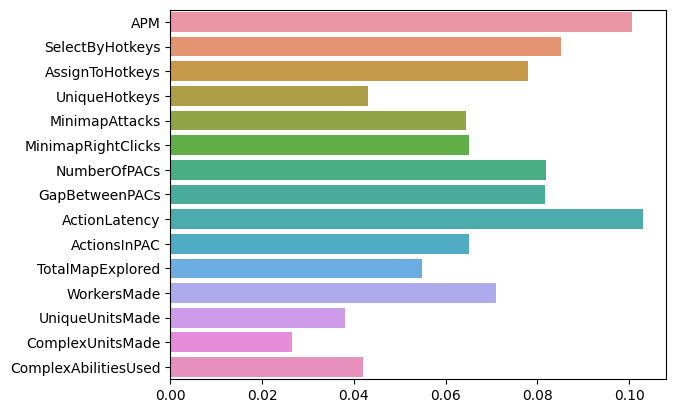

In [72]:
sns.barplot(x=random_forest_mdl.feature_importances_, y=random_forest_mdl.feature_names_in_)

In [73]:
for x, y, in zip(random_forest_mdl.feature_importances_, random_forest_mdl.feature_names_in_):
    print(f'- {y}: {np.round(np.round(x, 4) * 100, 2)}')

- APM: 10.05
- SelectByHotkeys: 8.51
- AssignToHotkeys: 7.79
- UniqueHotkeys: 4.3
- MinimapAttacks: 6.44
- MinimapRightClicks: 6.5
- NumberOfPACs: 8.19
- GapBetweenPACs: 8.16
- ActionLatency: 10.3
- ActionsInPAC: 6.51
- TotalMapExplored: 5.49
- WorkersMade: 7.1
- UniqueUnitsMade: 3.81
- ComplexUnitsMade: 2.65
- ComplexAbilitiesUsed: 4.2


Let's get the high tier dataset and rerun the experiments on those.

In [54]:
high_tier_df = df[df['LeagueIndex'].isin([6, 7, 8])]
high_tier_df['LeagueIndex'].value_counts()

LeagueIndex
6    621
8     55
7     35
1      0
2      0
3      0
4      0
5      0
Name: count, dtype: int64

Although our classes are imbalanced, let's run the models to see how they perform and then I'll decide whether I'll need to address class imbalances.

In [55]:
# Define our new X and y
X_high = high_tier_df.drop(['LeagueIndex'], axis=1) 
y_high = high_tier_df['LeagueIndex']

# Define our new train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_high, y_high, test_size=0.3, random_state=100)

# Perform grid search for each classifier
best_models = perform_experiments(X_train, X_test, y_train, y_test)

Classifier: LogisticRegression
Train Accuracy: 89.94
Test Accuracy: 91.59

Classifier: RandomForestClassifier
Train Accuracy: 100.0
Test Accuracy: 92.06

Classifier: GradientBoostingClassifier
Train Accuracy: 100.0
Test Accuracy: 91.12

Classifier: SVC
Train Accuracy: 89.34
Test Accuracy: 91.12

Classifier: KNeighborsClassifier
Train Accuracy: 88.73
Test Accuracy: 91.59

Classifier: DecisionTreeClassifier
Train Accuracy: 95.17
Test Accuracy: 85.98

Classifier: GaussianNB
Train Accuracy: 84.31
Test Accuracy: 85.98



Below we can see the test precision for each class, which shows that the model wasn't able to classify any League 7 correctly and only half of the League 8 correctly. Although the model correctly classifies all League 6 correctly, it's expected since we have a lot more datapoints for League 6.

In [370]:
precision_score(best_models[1].predict(X_test), y_test, average=None)

array([1. , 0. , 0.5])

In [65]:
for x, y, in zip(best_models[1].feature_importances_, best_models[1].feature_names_in_):
    print(f'- {y}: {np.round(np.round(x, 4) * 100, 2)}')

- APM: 13.31
- SelectByHotkeys: 7.63
- AssignToHotkeys: 11.01
- UniqueHotkeys: 2.62
- MinimapAttacks: 10.02
- MinimapRightClicks: 4.91
- NumberOfPACs: 6.08
- GapBetweenPACs: 13.37
- ActionLatency: 9.83
- ActionsInPAC: 4.42
- TotalMapExplored: 3.84
- WorkersMade: 4.74
- UniqueUnitsMade: 2.64
- ComplexUnitsMade: 2.33
- ComplexAbilitiesUsed: 3.25


<Axes: >

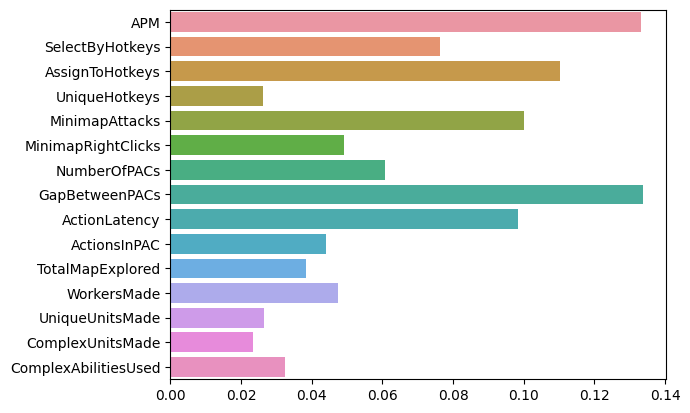

In [57]:
sns.barplot(x=best_models[1].feature_importances_, y=best_models[1].feature_names_in_)

Our accuracies above were great, but we can see that the prediction accuracy within our smaller ranks (7 & 8) didn't have as great for classes 7 or 8.

There are two ways I would address these class imbalances:
1. Weighing the classes in the models higher than the majority class
2. Oversampling or undersampling the majority class

With more time I could try these methods, but tree algorithms (which are performing the best) are robust to class imbalances.

/var/folders/xz/c6nwhmsx76x48gyt03kk4g1w0000gn/T/ipykernel_72336/860365660.py:32: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



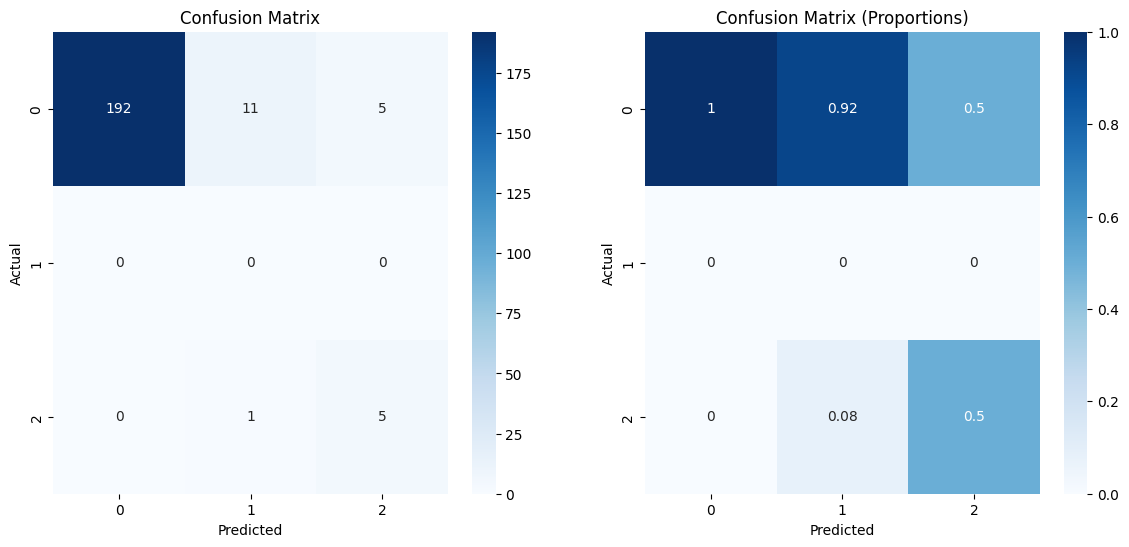

In [373]:
rf_conf_matrix = confusion_matrix(best_models[1].predict(X_test), y_test)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Create a heatmap for the confusion matrix
sns.heatmap(rf_conf_matrix, ax=axes[0], annot=True, fmt="d", cmap="Blues")

# Add labels, title, and axis ticks
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
axes[0].set_title("Confusion Matrix")
plt.xticks(np.arange(3) + 0.5, labels=np.unique(y_test))
plt.yticks(np.arange(3) + 0.5, labels=np.unique(y_test), rotation=0)

class_counts = y_test.value_counts()

# Turns the counts into proportion of each class correctly classified
prop_6 = rf_conf_matrix[:, 0] / class_counts[6]
prop_7 = rf_conf_matrix[:, 1] / class_counts[7]
prop_8 = rf_conf_matrix[:, 2] / class_counts[8]
rf_conf_matrix = np.hstack([prop_6, prop_7, prop_8]).reshape((3, 3)).T
rf_conf_matrix = np.round(rf_conf_matrix, 2)

# Create a heatmap for the confusion matrix
sns.heatmap(rf_conf_matrix, ax=axes[1], annot=True, cmap="Blues")

axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
axes[1].set_title("Confusion Matrix (Proportions)")

# show the figure
fig.show()

----

## Model Interpretations

----

Our main model which included all of the League Indicies 1-8 performed okay. It's likely due to the class imbalance that the model couldn't classify the undersampled leagues as well. From the trends within the data, that were observed earlier, I can imagine that with more data the models would be able to perform a lot better on the test sets.

**Best Model**
- **Random Forest**
    - Train Accuracy: 100%
    - Test Accuracy: ~41.53%

The Random Forest found that the best features to differentiate between the Leagues was Action Latency followed closely by Actions Per Minute (APM). How quickly a player performs actions and how many actions they perform in a minute are tied together and are the most important to differentiate between lower and higher tier players.

**5 Most Important Features**
- ActionLatency: 10.3
- APM: 10.05
- SelectByHotkeys: 8.51
- NumberOfPACs: 8.19
- GapBetweenPACs: 8.16

----

For the model based on data from League Indicies 6-8 (High-Tier Models), the Random Forest Classifier Achieved 92.06% accuracy on the test sets. Knowing that the data is extremely imbalanced, around 80% of the data points from League 6 and 20% in League 7 and 8, I used precision to get a better idea of how many values we could have classified correctly within each class. Precision showed that although classifying all of League 6 correctly, the model didn't correctly classify any of League 7 correctly and only classified 50% of League 8 values correctly. It's most likely that this performance drop is due to the class imbalance; With more data the model would be able to perform better accross all classes.

**Best High-Tier Model(s)**
- **Random Forest**
    - Train Accuracy: 100.0%
    - Test Accuracy: 92.06%
    - **Test Precision:** 
        - League 6: 100%
        - League 7: 0%
        - League 8: 50%

Within the higher ranks, the most important feature changes to Gap Between Perception Action Cycles (PACs). A PAC is a shift of screen to a new location followed by at least one action. This shows that as you go up in ranks, the players action latency gets more similar, but being able to perform actions in multiple different areas of the game quickly is more important.

**5 Most Important Features**
- GapBetweenPACs: 13.37
- APM: 13.31
- AssignToHotkeys: 11.01
- MinimapAttacks: 10.02
- ActionLatency: 9.83

----

## Advice to Stakeholders

----

With the following question in mind:

> Hypothetical: after seeing your work, your stakeholders come to you and say that they <br> can collect more data, but want your guidance before starting. How would you advise <br> them based on your EDA and model results?

I would first suggest we narrow our data collection to just high tier players in Leagues 6-8. As an Esports Organization, we don't care so much about what differentiates a low tier player from a higher tier, but what the difference between a top tier and a professional player. 

I would next offer three tools that could be made to help EG.
1. Using our model, we can see which of our players classified lower than a professional and then see which features caused them to be incorrectly classified. We can then take this information to tell our player's what skills they need to improve to perform better.
2. Since our model also gives us importance of different player statistics, I would advise a way to build a tool that can take in our player's statistics to see where our player's fall against other pros. If they are below average, we they can use that knowledge to know where they can improve. This tool is slightly different than the above tool because it analyzes just the statistics without regards for rank. The above tool would be useful if a player is performing significantly below average to understand the overall picture in regards to rank.
3. For recruiting, we can use the model to intake high tier players or potential candidates. The goal would be to build a model with as close to 100% accuracy as possible. Then, if we encounter any players that are not already pros (anyone in League 6 or 7), that get classified as League 8, we might consider that they could be the next EG recruit.